 Hoek° Zijde  Runs   Gem.flux        σ
     0     E     2 136.832195 1.928937
     0     W     2 136.832195 1.928937
    20     E     2  91.578595 1.861215
    20     W     2 113.633288 0.688573
    40     E     2  43.922823 0.415700
    40     W     2  49.674626 1.008115
    60     E     2  14.342456 0.132630
    60     W     2  15.282204 0.260446

Fit:  A = 125.3 ± 0.785,  n = 3.213 ± 0.01707
χ²/dof = 889.39 / 4  →  222.35



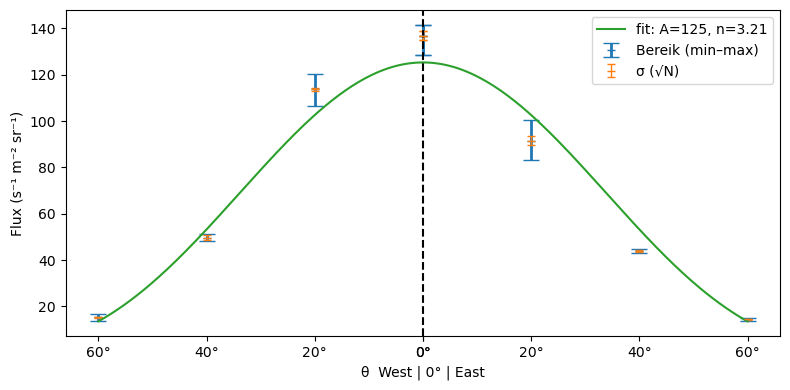

In [91]:
import math
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

x_0 = 4.5e-2
y_0 = 20.0e-2
h_0 = 86.0e-2

def get_x_projection(theta_deg):
    """Halve breedte‐projectie bij helling θ (deg)."""
    return x_0 * math.cos(math.radians(theta_deg))


def get_h_projection(theta_deg):
    """Projectie van de middenafstand h₀ op de verticaal."""
    return h_0 * math.cos(math.radians(theta_deg))


def get_solid_angle(theta_deg):
    x_proj = get_x_projection(theta_deg)
    h_proj = get_h_projection(theta_deg)
    return 4 * math.atan(
        (x_proj * y_0)
        / ((h_proj / 2) * math.sqrt(x_proj ** 2 + y_0 ** 2 + (h_proj / 2) ** 2))
    )


def get_area(theta_deg):
    """Effectief oppervlak bij hoek θ (deg)."""
    return get_x_projection(theta_deg) * y_0

stats = {}
for name in files:
    if not pathlib.Path(name).exists():
        continue

    parts = name.split("_")
    angle = int(parts[1])        # 0, 20, 40, 60 … (graden)
    side  = "E" if "E" in parts else "W" if "W" in parts else "E"

    header = pd.read_csv(name, nrows=1)
    N = int(header["Total coincidences"][0])
    t = float(header["Total runtime (s)"][0])

    area        = get_area(angle)
    solid_angle = get_solid_angle(angle)
    flux_run    = N / (t * area * solid_angle)

    key = (angle, side)
    d = stats.setdefault(key, {"N": 0, "t": 0.0, "runs": []})
    d["N"]    += N
    d["t"]    += t
    d["runs"].append(flux_run)

# Symmetriepunt 0° spiegelen indien nodig
if (0, "E") in stats and (0, "W") not in stats:
    stats[(0, "W")] = stats[(0, "E")]

# ------------------------------------------------------------
# Samenvatten & foutbalken
# ------------------------------------------------------------
rows, x, y, lo, hi, sigma = [], [], [], [], [], []
for (angle, side), d in sorted(stats.items()):
    area        = get_area(angle)
    solid_angle = get_solid_angle(angle)
    mean  = d["N"] / (d["t"] * area * solid_angle)
    err   = math.sqrt(d["N"]) / (d["t"] * area * solid_angle)

    rows.append([angle, side, len(d["runs"]), mean, err])

    pos = angle if side == "E" else -angle
    x.append(pos)
    y.append(mean)
    lo.append(max(0, mean - min(d["runs"])))  # nooit negatief -> Gaf veel problemen met de yerr, bij plotten.
    hi.append(max(0, max(d["runs"]) - mean))
    sigma.append(err)

# DataFrame voor console‑weergave
result = pd.DataFrame(rows, columns=["Hoek°", "Zijde", "Runs", "Gem.flux", "σ"])
print(result.to_string(index=False))

# Fit: I(θ) = A · cosⁿ θ  (θ in graden, |θ| voor symmetrie)
def cosn(theta_deg, A, n):
    return A * np.cos(np.deg2rad(np.abs(theta_deg))) ** n

x_arr     = np.array(x)
y_arr     = np.array(y)
sigma_arr = np.array(sigma)
mask = np.abs(x_arr) > 0            # negeer 0° bij fit -> kreeg gekke uitslagen hierdoor

popt, pcov = curve_fit(
    cosn, x_arr[mask], y_arr[mask], p0=(y_arr.max(), 2.0), sigma=sigma_arr[mask],
    absolute_sigma=True
)
perr = np.sqrt(np.diag(pcov))
chi2 = np.sum(((y_arr[mask] - cosn(x_arr[mask], *popt)) / sigma_arr[mask]) ** 2)
dof  = mask.sum() - len(popt)

print(
    f"\nFit:  A = {popt[0]:.4g} ± {perr[0]:.4g},  n = {popt[1]:.4g} ± {perr[1]:.4g}"
)
print(f"χ²/dof = {chi2:.2f} / {dof:d}  →  {chi2/dof:.2f}\n")

# Plot
lo    = np.clip(lo,    0, None)
hi    = np.clip(hi,    0, None)
sigma = np.clip(sigma, 0, None)

plt.figure(figsize=(8, 4))
plt.errorbar(x, y, yerr=[lo, hi], fmt="_", elinewidth=2, capsize=6,
             label="Bereik (min–max)")
plt.errorbar(x, y, yerr=sigma, fmt="_", elinewidth=1, capsize=3,
             label="σ (√N)")

# Fit‑curve over ±60°
grid = np.linspace(-60, 60, 301)
plt.plot(grid, cosn(grid, *popt), label=f"fit: A={popt[0]:.3g}, n={popt[1]:.2f}")

plt.axvline(0, color="k", ls="--")
plt.xticks(x, [f"{abs(v):.0f}°" for v in x])
plt.xlabel("θ  West | 0° | East")
plt.ylabel("Flux (s⁻¹ m⁻² sr⁻¹)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()
